In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random 
from fitter import Fitter

from settings import Config
from mysql_db import Database
import pdcast as pdc
import s3_upload_download as s3con

import scipy
from scipy import stats
from scipy.stats import gamma, lognorm
import pylab as py

from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import os


# NOTEBOOK DESCRIPTION: 

Modeling the claim severity. More specifically, the purpose is to a regression-type algorithm to obtain the average severity for each combination of age and cylinder capaciy (the 2 predictors to be used).

Steps:
1. Establish best fit PDF (Probability Density Function)
2. Model severity using GLM (Generalized Linear Model)
3. Model severity using GAM (Generalized Additive Model)

The LINK FUNCTION used is the Log-Link (logarithmic), as this is widely used in the actuarial study of severity.

In [68]:
# initialise the s3_connector object needed to read/write files into an S3 bucket
s3con = s3con.s3_connector()

In [3]:
# to prevent displaying results in scientific notation
pd.options.display.float_format = '{:.2f}'.format

First, prepare the input.

In [4]:
# load the tables
claim_vals = s3con.read('autoturisme_pf_mat_outlier_status.feather')
predictors = s3con.read('autoturisme_pf.feather')

In [5]:
claim_vals.head()

,idEvent,total_val,idPolita,log_total_val,outlier_type
0,100001972018-12-02,10815.00,10000197,9.29,no_out
1,100004462018-10-08,2635.00,10000446,7.88,no_out
2,100005852018-07-07,9255.00,10000585,9.13,no_out
3,100006982018-05-27,5097.00,10000698,8.54,no_out
4,100007012018-08-09,18872.00,10000701,9.85,no_out


In [6]:
predictors.head()

,idPolita,capacitate,varsta
0,2230446,1389,25
1,2230447,1781,26
2,2230448,1598,62
3,2230449,1596,26
4,2230450,1390,40


In [7]:
# bin cylinder capacity into multiple categories
cap_bins = [predictors.capacitate.min(), 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500, 4000, 4500, predictors.capacitate.max()]
cap_labels = ['<=1000', '1001-1200', '1201-1400', '1401-1600', '1601-1800', '1801-2000', '2001-2500', '2501-3000',
          '3001-3500', '3501-4000', '4001-4500', '>4500']

# bin age into multiple categories
age_bins = [predictors.varsta.min(), 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, predictors.varsta.max()]
age_labels = ['<=25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '>75']


input = claim_vals.merge(predictors, on = 'idPolita', how = 'left')
input = input.assign(age_cat = pd.cut(x = input.varsta, bins = age_bins, labels = age_labels, include_lowest = True),
                cap_cat = pd.cut(x = input.capacitate, bins = cap_bins, labels = cap_labels, include_lowest = True))
        

input.head()

,idEvent,total_val,idPolita,log_total_val,outlier_type,capacitate,varsta,age_cat,cap_cat
0,100001972018-12-02,10815.00,10000197,9.29,no_out,1896,47,45-50,1801-2000
1,100004462018-10-08,2635.00,10000446,7.88,no_out,1991,41,40-45,1801-2000
2,100005852018-07-07,9255.00,10000585,9.13,no_out,2497,39,35-40,2001-2500
3,100006982018-05-27,5097.00,10000698,8.54,no_out,1975,25,<=25,1801-2000
4,100007012018-08-09,18872.00,10000701,9.85,no_out,1910,72,70-75,1801-2000


## Step I - Finding best PDF

Finding the best PDF allows us to determine which distribution family to use when modeling the severity.


Fitting 5 distributions: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
invgauss,0.00,2570.14,-13450203.50,0.00,0.02,0.00
gamma,0.00,2755.24,-12071961.55,0.08,0.08,0.00
lognorm,0.00,2723.18,-11289358.07,0.79,0.72,0.00
weibull,inf,inf,inf,inf,NaN,NaN
paretto,inf,inf,inf,inf,NaN,NaN


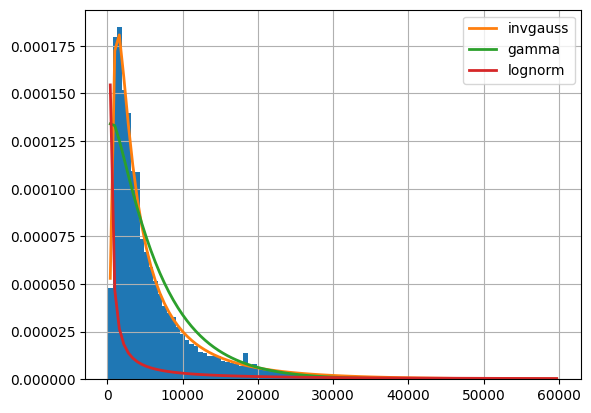

In [8]:
# start with the Fitter
# NOTE: I am using the input without the outliers, by selecting only 'no_out' in the outlier_type column
f = Fitter(input.query("outlier_type == 'no_out'").total_val, distributions = ['gamma', 'lognorm', 'weibull', 'invgauss', 'paretto']) 
f.fit()
f.summary()

In [9]:
# obtain detailed stats on the Inverse Gaussian distribution

dist = getattr(stats, 'invgauss')
param_lgn = dist.fit(input.query("outlier_type == 'no_out'").total_val)
shape = param_lgn[0]
loc = param_lgn[1]
scale = param_lgn[2]

# Kolmogorov-Smirnov test (goodness of fit)
lgn_kst, lgn_ksp = stats.kstest(input.query("outlier_type == 'no_out'").total_val, "invgauss", param_lgn)

print(f"Inverse Gaussian param_lgn\nShape(std): {param_lgn[0]:.4f}, Location(mu): {param_lgn[1]:.4f}, Scale: {param_lgn[2]:.4f}\nKS test: {lgn_kst}, p-val: {lgn_ksp}")

Inverse Gaussian param_lgn
Shape(std): 1.4366, Location(mu): -147.2680, Scale: 4655.6342
KS test: 0.01572454753950936, p-val: 9.465269187248442e-85


In [10]:
# obtain detailed stats on the Gamma distribution

dist = getattr(stats, 'gamma')
param_lgn = dist.fit(input.query("outlier_type == 'no_out'").total_val)
shape = param_lgn[0]
loc = param_lgn[1]
scale = param_lgn[2]

# Kolmogorov-Smirnov test (goodness of fit)
lgn_kst, lgn_ksp = stats.kstest(input.query("outlier_type == 'no_out'").total_val, "gamma", param_lgn)

print(f"Gamma param_lgn\nShape(std): {param_lgn[0]:.4f}, Location(mu): {param_lgn[1]:.4f}, Scale: {param_lgn[2]:.4f}\nKS test: {lgn_kst}, p-val: {lgn_ksp}")

Gamma param_lgn
Shape(std): 1.0898, Location(mu): 79.8380, Scale: 5687.5909
KS test: 0.07701684127047287, p-val: 0.0


In [11]:
# obtain detailed stats on the Log-normal distribution

dist = getattr(stats, 'lognorm')
param_lgn = dist.fit(input.query("outlier_type == 'no_out'").total_val)
shape = param_lgn[0]
loc = param_lgn[1]
scale = param_lgn[2]

# Kolmogorov-Smirnov test (goodness of fit)
lgn_kst, lgn_ksp = stats.kstest(input.query("outlier_type == 'no_out'").total_val, "lognorm", param_lgn)

print(f"Log-normal param_lgn\nShape(std): {param_lgn[0]:.4f}, Location(mu): {param_lgn[1]:.4f}, Scale: {param_lgn[2]:.4f}\nKS test: {lgn_kst}, p-val: {lgn_ksp}")

Log-normal param_lgn
Shape(std): 7.3598, Location(mu): 80.0000, Scale: 4.7699
KS test: 0.7180204747390487, p-val: 0.0


CONCLUSION: 
1. The Inverse Gaussian distribution appears to be noticeably worse than the other two.
2. Log-normal is the best.
3. I will use both Log-normal and Gamma (for reference)

Finally, before starting the modeling process, I will calculate a LOADING FACTOR based on the outliers. This will be later inserted into the final prediction made by the model.

In [12]:
loading_factor = (input.query("outlier_type != 'no_out'").total_val.sum()/input.total_val.sum()) + 1
loading_factor

1.1563839468351893

## Step II - GLM Modeling

GLM is the standard model used by actuaries when modeling claim severity.

Overview:
1. Null hypothesis fit of claim values (i.e. no predictors)

2. Categorical Predictors:
    - Claim values and Age;
    - Claim values and Cylinder Capacity;
    - Claim values, Age and Cylinder Capacity.

3. Continuous Predictors:
    - Claim values and Age;
    - Claim values and Cylinder Capacity;
    - Claim values, Age and Cylinder Capacity.

NOTE: KPMG used the predictors as categorical, however, the relationship between them and the claim values (i.e. severity) may be better modeled if they were continuous. As such, I will explore both.

NOTE II: The above operations will be performed on the input events, MINUS the outliers identified thusly:
1. Claims values >60K;
2. Those identified by the Local Outlier Factor algorithm.

### Prepare inputs for modeling

### Null hypothesis

In [13]:
# I will first calculate the empiric severity (i.e. mean severity) and empiric deviation
# these will serve as benchmarks, to be compared to the results of future algorithms

empiric_severity = input.query("outlier_type == 'no_out'").total_val.mean()
empiric_deviation = input.query("outlier_type == 'no_out'").total_val.std()
print(f"Empiric average severity (outliers excluded) = {empiric_severity:,.1f}")
print(f"Empiric severity deviation (outliers excluded) = {empiric_deviation:,.1f}")

Empiric average severity (outliers excluded) = 6,541.0
Empiric severity deviation (outliers excluded) = 7,873.7


In [14]:
# Null hypothesis for Gamma distribution

patsy_null = 'total_val ~ 1'
null_GAM = glm(patsy_null, data = input.query("outlier_type == 'no_out'"), 
            family = sm.families.Gamma(link=sm.families.links.log())).fit()

null_GAM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392588
Model Family:                   Gamma   Df Model:                            0
Link Function:                    log   Scale:                          1.4490
Method:                          IRLS   Log-Likelihood:            -3.8657e+06
Date:                Mon, 13 Feb 2023   Deviance:                   4.0125e+05
Time:                        09:03:20   Pearson chi2:                 5.69e+05
No. Iterations:                     8   Pseudo R-squ. (CS):          4.774e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7858      0.002   4573.156      0.000       8.782       8.790
==============================================================================
"""

In [15]:
# compare the avg. severity predicted by the NULL hypothesis to the actual average severity of the DF
null_GAM_avg = np.exp(null_GAM.params[0])
print(f"Average severity predicted: {null_GAM_avg:,.0f}\nDelta-to-Empirical: {null_GAM_avg/empiric_severity-1:.2%}")

Average severity predicted: 6,541
Delta-to-Empirical: -0.00%


In [16]:
# Null hypothesis for Log-normal distribution

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
null_LOG = glm(patsy_null, data = input.query("outlier_type == 'no_out'"), 
            family = sm.families.Gaussian()).fit()

null_LOG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392588
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          1.0116
Method:                          IRLS   Log-Likelihood:            -5.5932e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9713e+05
Time:                        09:03:22   Pearson chi2:                 3.97e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          3.245e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2748      0.002   5155.000      0.000       8.272       8.278
==============================================================================
"""

In [17]:
# when using the logarithm of the values of a population, their Standard Deviation becomes altered such that
# it cannot be compared to that of the original population or another not-logarithmic population

# this function accounts of this issue and attempts to create a comparable Standard Deviation  
def calc_std(data):
    y = data.values
    log_y = np.log(y)
    mu = np.mean(log_y)
    delta = log_y - mu
    deltasq = delta**2
    totdelta = np.sum(deltasq)
    return np.sqrt(totdelta / (len(y)-1))

In [18]:
# compare the avg. severity predicted by the NULL hypothesis to the actual average severity of the DF
std = calc_std(input.query("outlier_type == 'no_out'").total_val)
null_LOG_avg = np.exp(null_LOG.params[0]+0.5*std**2)
print(f"Average severity predicted: {null_LOG_avg:,.0f}\nDelta-to-Empirical: {null_LOG_avg/empiric_severity-1:.2%}")

Average severity predicted: 6,507
Delta-to-Empirical: -0.52%


For both distributions types, the null hypothesis predicted the average of the whole sample very well, suggesting that they are suitable for the sample.

### Categorical variables

In [19]:
# patsy variables for modeling the categorical variables
GAM_patsy_cap = 'total_val ~ C(cap_cat)'
GAM_patsy_age = 'total_val ~ C(age_cat)'
GAM_patsy_cmb = 'total_val ~ C(cap_cat) + C(age_cat)'

LOG_patsy_cap = 'log_total_val ~ C(cap_cat)'
LOG_patsy_age = 'log_total_val ~ C(age_cat)'
LOG_patsy_cmb = 'log_total_val ~ C(cap_cat) + C(age_cat)'

#### GAMMA Distribution

In [28]:
# Gamma - Severity and cylinder capacity 
GAM_CAT_cap = glm(GAM_patsy_cap, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CAT_cap.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392577
Model Family:                   Gamma   Df Model:                           11
Link Function:                    log   Scale:                          1.4384
Method:                          IRLS   Log-Likelihood:            -3.8640e+06
Date:                Mon, 13 Feb 2023   Deviance:                   3.9846e+05
Time:                        09:21:10   Pearson chi2:                 5.65e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.004926
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.6762      0.011    805.674      0.000       8.655       8.697
C(cap_cat)[T.1001-1200]     0.0166      0.014      1.178      0.239      -0.011       0.044
C(cap_cat)[T.1201-1400]     0.0352      0.012      2.982      0.003       0.012       0.058
C(cap_cat)[T.1401-1600]     0.0495      0.011      4.331      0.000       0.027       0.072
C(cap_cat)[T.1601-1800]     0.0865      0.013      6.837      0.000       0.062       0.111
C(cap_cat)[T.1801-2000]     0.1492      0.011     13.237      0.000       0.127       0.171
C(cap_cat)[T.2001-2500]     0.2644      0.014     19.387      0.000       0.238       0.291
C(cap_cat)[T.2501-3000]     0.3327      0.014     23.783      0.000       0.305       0.360
C(cap_cat)[T.3001-3500]     0.3112      0.042      7.367      0.000       0.228       0.394
C(cap_cat)[T.3501-4000]     0.3037      0.059      5.145      0.000       0.188       0.419
C(cap_cat)[T.4001-4500]     0.3250      0.070      4.668      0.000       0.189       0.461
C(cap_cat)[T.>4500]         0.4332      0.066      6.600      0.000       0.305       0.562
===========================================================================================
"""

In [29]:
# Gamma - Severity and age
GAM_CAT_age = glm(GAM_patsy_age, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CAT_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392577
Model Family:                   Gamma   Df Model:                           11
Link Function:                    log   Scale:                          1.4477
Method:                          IRLS   Log-Likelihood:            -3.8653e+06
Date:                Mon, 13 Feb 2023   Deviance:                   4.0047e+05
Time:                        09:21:23   Pearson chi2:                 5.68e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.001364
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.9137      0.008   1054.395      0.000       8.897       8.930
C(age_cat)[T.25-30]    -0.0519      0.011     -4.779      0.000      -0.073      -0.031
C(age_cat)[T.30-35]    -0.1090      0.010    -10.497      0.000      -0.129      -0.089
C(age_cat)[T.35-40]    -0.1503      0.010    -14.738      0.000      -0.170      -0.130
C(age_cat)[T.40-45]    -0.1248      0.010    -12.151      0.000      -0.145      -0.105
C(age_cat)[T.45-50]    -0.1334      0.010    -13.211      0.000      -0.153      -0.114
C(age_cat)[T.50-55]    -0.1254      0.011    -11.917      0.000      -0.146      -0.105
C(age_cat)[T.55-60]    -0.1649      0.011    -15.097      0.000      -0.186      -0.143
C(age_cat)[T.60-65]    -0.1584      0.010    -15.355      0.000      -0.179      -0.138
C(age_cat)[T.65-70]    -0.1793      0.011    -16.616      0.000      -0.200      -0.158
C(age_cat)[T.70-75]    -0.1529      0.013    -11.827      0.000      -0.178      -0.128
C(age_cat)[T.>75]      -0.1856      0.014    -13.035      0.000      -0.214      -0.158
=======================================================================================
"""

In [30]:
# Gamma - Severity, Age and cylinder capacity 
GAM_CAT_both = glm(GAM_patsy_cmb, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CAT_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392566
Model Family:                   Gamma   Df Model:                           22
Link Function:                    log   Scale:                          1.4369
Method:                          IRLS   Log-Likelihood:            -3.8636e+06
Date:                Mon, 13 Feb 2023   Deviance:                   3.9776e+05
Time:                        09:21:38   Pearson chi2:                 5.64e+05
No. Iterations:                    10   Pseudo R-squ. (CS):           0.006174
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.8070      0.014    648.896      0.000       8.780       8.834
C(cap_cat)[T.1001-1200]     0.0164      0.014      1.159      0.247      -0.011       0.044
C(cap_cat)[T.1201-1400]     0.0328      0.012      2.783      0.005       0.010       0.056
C(cap_cat)[T.1401-1600]     0.0475      0.011      4.153      0.000       0.025       0.070
C(cap_cat)[T.1601-1800]     0.0850      0.013      6.712      0.000       0.060       0.110
C(cap_cat)[T.1801-2000]     0.1435      0.011     12.718      0.000       0.121       0.166
C(cap_cat)[T.2001-2500]     0.2646      0.014     19.399      0.000       0.238       0.291
C(cap_cat)[T.2501-3000]     0.3280      0.014     23.436      0.000       0.301       0.355
C(cap_cat)[T.3001-3500]     0.3144      0.042      7.446      0.000       0.232       0.397
C(cap_cat)[T.3501-4000]     0.3026      0.059      5.129      0.000       0.187       0.418
C(cap_cat)[T.4001-4500]     0.3251      0.070      4.672      0.000       0.189       0.462
C(cap_cat)[T.>4500]         0.4343      0.066      6.619      0.000       0.306       0.563
C(age_cat)[T.25-30]        -0.0517      0.011     -4.770      0.000      -0.073      -0.030
C(age_cat)[T.30-35]        -0.1193      0.010    -11.519      0.000      -0.140      -0.099
C(age_cat)[T.35-40]        -0.1557      0.010    -15.322      0.000      -0.176      -0.136
C(age_cat)[T.40-45]        -0.1294      0.010    -12.639      0.000      -0.149      -0.109
C(age_cat)[T.45-50]        -0.1372      0.010    -13.637      0.000      -0.157      -0.118
C(age_cat)[T.50-55]        -0.1236      0.010    -11.790      0.000      -0.144      -0.103
C(age_cat)[T.55-60]        -0.1660      0.011    -15.242      0.000      -0.187      -0.145
C(age_cat)[T.60-65]        -0.1496      0.010    -14.551      0.000      -0.170      -0.129
C(age_cat)[T.65-70]        -0.1658      0.011    -15.403      0.000      -0.187      -0.145
C(age_cat)[T.70-75]        -0.1394      0.013    -10.810      0.000      -0.165      -0.114
C(age_cat)[T.>75]          -0.1752      0.014    -12.332      0.000      -0.203      -0.147
===========================================================================================
"""

#### LOG-NORMAL Distribution

In [31]:
# Log-normal - Severity and cylinder capacity 
LOG_CAT_cap = glm(LOG_patsy_cap, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CAT_cap.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392577
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                          1.0060
Method:                          IRLS   Log-Likelihood:            -5.5822e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9491e+05
Time:                        09:22:14   Pearson chi2:                 3.95e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.005599
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1912      0.009    909.541      0.000       8.174       8.209
C(cap_cat)[T.1001-1200]     0.0009      0.012      0.073      0.942      -0.022       0.024
C(cap_cat)[T.1201-1400]     0.0188      0.010      1.899      0.058      -0.001       0.038
C(cap_cat)[T.1401-1600]     0.0362      0.010      3.788      0.000       0.017       0.055
C(cap_cat)[T.1601-1800]     0.0593      0.011      5.600      0.000       0.039       0.080
C(cap_cat)[T.1801-2000]     0.1198      0.009     12.710      0.000       0.101       0.138
C(cap_cat)[T.2001-2500]     0.2195      0.011     19.248      0.000       0.197       0.242
C(cap_cat)[T.2501-3000]     0.3031      0.012     25.910      0.000       0.280       0.326
C(cap_cat)[T.3001-3500]     0.2639      0.035      7.470      0.000       0.195       0.333
C(cap_cat)[T.3501-4000]     0.2782      0.049      5.635      0.000       0.181       0.375
C(cap_cat)[T.4001-4500]     0.3084      0.058      5.296      0.000       0.194       0.422
C(cap_cat)[T.>4500]         0.4069      0.055      7.412      0.000       0.299       0.515
===========================================================================================
"""

In [32]:
# Log-normal - Severity and age
LOG_CAT_age = glm(LOG_patsy_age, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CAT_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392577
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                          1.0094
Method:                          IRLS   Log-Likelihood:            -5.5888e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9626e+05
Time:                        09:22:39   Pearson chi2:                 3.96e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.002207
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.4134      0.007   1191.888      0.000       8.400       8.427
C(age_cat)[T.25-30]    -0.0682      0.009     -7.509      0.000      -0.086      -0.050
C(age_cat)[T.30-35]    -0.1208      0.009    -13.929      0.000      -0.138      -0.104
C(age_cat)[T.35-40]    -0.1578      0.009    -18.538      0.000      -0.175      -0.141
C(age_cat)[T.40-45]    -0.1274      0.009    -14.851      0.000      -0.144      -0.111
C(age_cat)[T.45-50]    -0.1334      0.008    -15.826      0.000      -0.150      -0.117
C(age_cat)[T.50-55]    -0.1273      0.009    -14.491      0.000      -0.144      -0.110
C(age_cat)[T.55-60]    -0.1805      0.009    -19.792      0.000      -0.198      -0.163
C(age_cat)[T.60-65]    -0.1754      0.009    -20.362      0.000      -0.192      -0.158
C(age_cat)[T.65-70]    -0.1928      0.009    -21.390      0.000      -0.210      -0.175
C(age_cat)[T.70-75]    -0.1805      0.011    -16.718      0.000      -0.202      -0.159
C(age_cat)[T.>75]      -0.2135      0.012    -17.956      0.000      -0.237      -0.190
=======================================================================================
"""

In [33]:
# Log-normal - Severity, Age and cylinder capacity 
LOG_CAT_both = glm(LOG_patsy_cmb, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CAT_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392566
Model Family:                Gaussian   Df Model:                           22
Link Function:               identity   Scale:                          1.0040
Method:                          IRLS   Log-Likelihood:            -5.5783e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9413e+05
Time:                        09:23:12   Pearson chi2:                 3.94e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.007580
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.3339      0.011    734.603      0.000       8.312       8.356
C(cap_cat)[T.1001-1200]    -0.0007      0.012     -0.058      0.954      -0.024       0.022
C(cap_cat)[T.1201-1400]     0.0161      0.010      1.633      0.102      -0.003       0.035
C(cap_cat)[T.1401-1600]     0.0326      0.010      3.413      0.001       0.014       0.051
C(cap_cat)[T.1601-1800]     0.0559      0.011      5.281      0.000       0.035       0.077
C(cap_cat)[T.1801-2000]     0.1117      0.009     11.847      0.000       0.093       0.130
C(cap_cat)[T.2001-2500]     0.2181      0.011     19.126      0.000       0.196       0.240
C(cap_cat)[T.2501-3000]     0.2953      0.012     25.238      0.000       0.272       0.318
C(cap_cat)[T.3001-3500]     0.2672      0.035      7.571      0.000       0.198       0.336
C(cap_cat)[T.3501-4000]     0.2765      0.049      5.605      0.000       0.180       0.373
C(cap_cat)[T.4001-4500]     0.3063      0.058      5.266      0.000       0.192       0.420
C(cap_cat)[T.>4500]         0.4095      0.055      7.466      0.000       0.302       0.517
C(age_cat)[T.25-30]        -0.0678      0.009     -7.486      0.000      -0.086      -0.050
C(age_cat)[T.30-35]        -0.1295      0.009    -14.961      0.000      -0.146      -0.113
C(age_cat)[T.35-40]        -0.1621      0.008    -19.082      0.000      -0.179      -0.145
C(age_cat)[T.40-45]        -0.1317      0.009    -15.389      0.000      -0.148      -0.115
C(age_cat)[T.45-50]        -0.1361      0.008    -16.176      0.000      -0.153      -0.120
C(age_cat)[T.50-55]        -0.1256      0.009    -14.330      0.000      -0.143      -0.108
C(age_cat)[T.55-60]        -0.1801      0.009    -19.786      0.000      -0.198      -0.162
C(age_cat)[T.60-65]        -0.1672      0.009    -19.448      0.000      -0.184      -0.150
C(age_cat)[T.65-70]        -0.1807      0.009    -20.090      0.000      -0.198      -0.163
C(age_cat)[T.70-75]        -0.1683      0.011    -15.617      0.000      -0.189      -0.147
C(age_cat)[T.>75]          -0.2040      0.012    -17.176      0.000      -0.227      -0.181
===========================================================================================
"""

### Continuous variables



In [34]:
# NOTE: To work with continuous age and cylinder capacity vaues, I must first rescale them, 
# since there is a difference of several orders of magnitude between them. 
# Left unchanged, this may cause the regression algorithm to attribute greater importance to cylinder capacity.

scaler = MinMaxScaler()
input['age_scaled'] = scaler.fit_transform(input.varsta.values.reshape(-1,1))
input['cap_scaled'] = scaler.fit_transform(input.capacitate.values.reshape(-1,1))

# patsy variables for modeling the continuous variables
GAM_patsy_cap = 'total_val ~ cap_scaled'
GAM_patsy_age = 'total_val ~ age_scaled'
GAM_patsy_cmb = 'total_val ~ cap_scaled + age_scaled'

LOG_patsy_cap = 'log_total_val ~ cap_scaled'
LOG_patsy_age = 'log_total_val ~ age_scaled'
LOG_patsy_cmb = 'log_total_val ~ cap_scaled + age_scaled'

#### GAMMA Distribution

In [35]:
# Gamma - Severity and cylinder capacity 
GAM_CON_cap = glm(GAM_patsy_cap, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CON_cap.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392587
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                          1.4390
Method:                          IRLS   Log-Likelihood:            -3.8641e+06
Date:                Mon, 13 Feb 2023   Deviance:                   3.9872e+05
Time:                        09:28:01   Pearson chi2:                 5.65e+05
No. Iterations:                    10   Pseudo R-squ. (CS):           0.004476
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5570      0.006   1483.883      0.000       8.546       8.568
cap_scaled     1.2351      0.030     41.477      0.000       1.177       1.294
==============================================================================
"""

In [36]:
# Gamma - Severity and age
GAM_CON_age = glm(GAM_patsy_age, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CON_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392587
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                          1.4485
Method:                          IRLS   Log-Likelihood:            -3.8655e+06
Date:                Mon, 13 Feb 2023   Deviance:                   4.0074e+05
Time:                        09:28:54   Pearson chi2:                 5.69e+05
No. Iterations:                    10   Pseudo R-squ. (CS):          0.0009034
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8582      0.004   2035.246      0.000       8.850       8.867
age_scaled    -0.2007      0.011    -18.698      0.000      -0.222      -0.180
==============================================================================
"""

In [37]:
# Gamma - Severity, Age and cylinder capacity 
GAM_CON_both = glm(GAM_patsy_cmb, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gamma(link=sm.families.links.log())).fit()
GAM_CON_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392586
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          1.4387
Method:                          IRLS   Log-Likelihood:            -3.8640e+06
Date:                Mon, 13 Feb 2023   Deviance:                   3.9835e+05
Time:                        09:29:21   Pearson chi2:                 5.65e+05
No. Iterations:                    10   Pseudo R-squ. (CS):           0.005128
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6247      0.007   1198.347      0.000       8.611       8.639
cap_scaled     1.2012      0.030     40.229      0.000       1.143       1.260
age_scaled    -0.1703      0.011    -15.879      0.000      -0.191      -0.149
==============================================================================
"""

#### LOG-NORMAL Distribution

In [38]:
# Log-normal - Severity and cylinder capacity 
LOG_CON_cap = glm(LOG_patsy_cap, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CON_cap.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392587
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.0064
Method:                          IRLS   Log-Likelihood:            -5.5831e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9510e+05
Time:                        09:30:23   Pearson chi2:                 3.95e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.005121
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0706      0.005   1673.514      0.000       8.061       8.080
cap_scaled     1.1181      0.025     44.895      0.000       1.069       1.167
==============================================================================
"""

In [39]:
# Log-normal - Severity and age
LOG_CON_age = glm(LOG_patsy_age, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CON_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392587
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.0100
Method:                          IRLS   Log-Likelihood:            -5.5901e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9652e+05
Time:                        09:30:45   Pearson chi2:                 3.97e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001547
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3552      0.004   2298.939      0.000       8.348       8.362
age_scaled    -0.2210      0.009    -24.653      0.000      -0.239      -0.203
==============================================================================
"""

In [40]:
# Log-normal - Severity, Age and cylinder capacity 
LOG_CON_both = glm(LOG_patsy_cmb, data = input.query("outlier_type == 'no_out'"), 
                    family = sm.families.Gaussian()).fit()
LOG_CON_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392586
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.0052
Method:                          IRLS   Log-Likelihood:            -5.5808e+05
Date:                Mon, 13 Feb 2023   Deviance:                   3.9464e+05
Time:                        09:31:11   Pearson chi2:                 3.95e+05
No. Iterations:                     3   Pseudo R-squ. (CS):           0.006291
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1478      0.006   1354.349      0.000       8.136       8.160
cap_scaled     1.0784      0.025     43.209      0.000       1.029       1.127
age_scaled    -0.1923      0.009    -21.441      0.000      -0.210      -0.175
==============================================================================
"""

### Results analysis

In [41]:
# sum up the results of all model and use several metrics for model comparison
results = {
    'Model': ['Gamma-Null', 'LogN-Null', 'Gamma-ctg', 'Log-Normal-ctg', 'Gamma-cnt', 'Log-Normal-cnt'],
    'AvgSev' : [null_GAM_avg, null_LOG_avg,0,0,0,0],
    'EmpSev' : [empiric_severity,empiric_severity,0,0,0,0],
    'AIC' : [null_GAM.aic, null_LOG.aic, GAM_CAT_both.aic, LOG_CAT_both.aic, GAM_CON_both.aic, LOG_CON_both.aic],
    'LLF' : [null_GAM.llf, null_LOG.llf, GAM_CAT_both.llf, LOG_CAT_both.llf, GAM_CON_both.llf, LOG_CON_both.llf],
    'Deviation' : [null_GAM.deviance, null_LOG.deviance, GAM_CAT_both.deviance, LOG_CAT_both.deviance, GAM_CON_both.deviance, LOG_CON_both.deviance]
}

df_res = pd.DataFrame(results)
df_res.style.format({
    'AvgSev' : '{:,.0f}',
    'EmpSev' : '{:,.0f}',
    'AIC' : '{:,.0f}',
    'LLF' : '{:,.0f}',
    'ChiSq' : '{:,.0f}',
    'Deviation' : '{:,.0f}',
})

,Model,AvgSev,EmpSev,AIC,LLF,Deviation
0,Gamma-Null,"6,541","6,541","7,731,355","-3,865,677","401,251"
1,LogN-Null,"6,507","6,541","1,118,638","-559,318","397,131"
2,Gamma-ctg,0,0,"7,727,317","-3,863,636","397,757"
3,Log-Normal-ctg,0,0,"1,115,706","-557,830","394,132"
4,Gamma-cnt,0,0,"7,727,932","-3,863,963","398,347"
5,Log-Normal-cnt,0,0,"1,116,172","-558,083","394,641"


The best model seems to be the GLM, based on the LOG-NORMAL distribution, using CATEGORICAL variables.

Now I will investigate how good this model is.

In [45]:
# Chi-Squared test is use to compare the observed values in the data to the expected values, 
# should the null hypothesis be true.

def chisquare_test(model):
    chi2 = model.null_deviance - model.deviance  # valoare chi-squared
    dfr = model.df_model # nr de predictori
    pvalue = 1 - stats.chi2.cdf(chi2, dfr)
    print(f"P-Value = {pvalue:.5f}")
    if pvalue < 0.05:
        print("Model seems usefull")
    else:
        print("Model seems useless")

In [46]:
chisquare_test(LOG_CAT_both)

P-Value = 0.00000
Model seems usefull


It appears that the model is statistically sig (i.e. not by chance)

In [47]:
# Goodness of Fit test calculates the chi2 parameter for nr of residuals and 95% confidence level
# it shows how much the model can explain the variation

def gof_test(model, conf_lev=0.05):
    df = model.df_resid
    chi2 = scipy.stats.chi2.ppf(1-conf_lev, df=df)
    if model.deviance < chi2:
        print("Deviance smaller than chi2, Model does a good job!")
    else:
        print("Deviance is bigger than chi2, Model is sub-optimal!")
    if model.pearson_chi2 < chi2:
        print("Person Chi2 smaller than chi2, Model does a good job!")
    else:
        print("Pearson Chi2 is bigger than chi2, Model is sub-optimal!")
    print(f"Chi2 threshold level: {chi2:,.0f}")

In [48]:
gof_test(LOG_CAT_both)

Deviance is bigger than chi2, Model is sub-optimal!
Pearson Chi2 is bigger than chi2, Model is sub-optimal!
Chi2 threshold level: 394,025


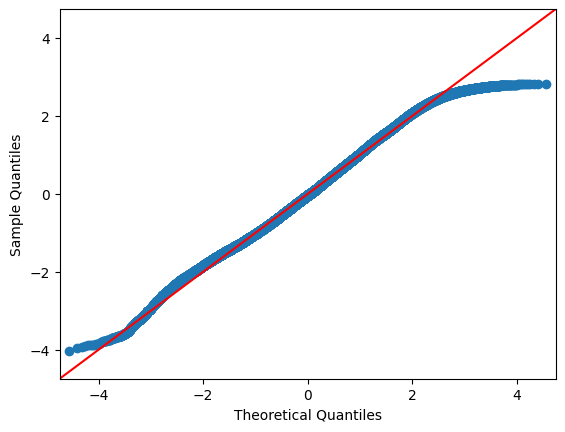

In [44]:
# A QQ-plot plots quantiles of the data versus quantiles of a distribution.
# by looking at the distribution of the residuals, I could find where the model struggles

sm.qqplot(LOG_CAT_both.resid_anscombe, stats.t, fit=True, line="45")
py.show()

The problem lies at the extremes of the distribution: the model struggles to predict the variation of the highest values, and to a lesser extent, the lowest values.

### Prediction

In [61]:
std = calc_std(input.query("outlier_type == 'no_out'").total_val)


yhat = (LOG_CAT_both.predict())
prediction = (
    input.query("outlier_type == 'no_out'")
    .filter(items=['age_cat', 'cap_cat', 'total_val'])
    .assign(log_cat_pred = np.exp(yhat + 0.5 * std**2)) # NOTE I: np.exp reverses the logarithm of the predicted claim values
)                                                         # NOTE II: multiplied yhat with loading factor to account for the outlier claims previously removed

prediction.head()


,age_cat,cap_cat,total_val,log_cat_pred
0,45-50,1801-2000,10815.00,6736.88
1,40-45,1801-2000,2635.00,6766.39
2,35-40,2001-2500,9255.00,7300.30
3,<=25,1801-2000,5097.00,7718.98
4,70-75,1801-2000,18872.00,6523.09


In [64]:
# create a category table
# I have also added the true average of each category for comparison

res_table = prediction.groupby(['age_cat', 'cap_cat']).agg({'log_cat_pred':'mean', 'total_val':'mean'})
res_table.head(12)

log_cat_pred  total_val
age_cat cap_cat                           
<=25    <=1000          6903.11    6856.27
        1001-1200       6898.41    6535.69
        1201-1400       7015.24    6829.77
        1401-1600       7131.98    7079.05
        1601-1800       7299.86    7213.55
        1801-2000       7718.98    7779.39
        2001-2500       8585.28    8850.76
        2501-3000       9274.35    8736.58
        3001-3500       9017.79    9270.52
        3501-4000       9101.37   10516.14
        4001-4500       9377.12    6575.32
        >4500          10396.20   20501.91

As expected from the QQ plot, the model struggled to predict the highest values well.

In [69]:
# save results table to S3

res_table.reset_index(drop = False, inplace = True) # feather cannot save multi index
res_table.to_feather('severity_glm_predictions.feather')
s3con.write('severity_glm_predictions.feather')
os.remove('severity_glm_predictions.feather')